#### Librerías y dependencias

In [1]:
import os, json
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json, pickle
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
output_model_dir = '/content/drive/MyDrive/atlas-del-crimen/models'
output_model = os.path.join(output_model_dir, 'modelo_total_dsexual_log.json')
output_model_features = os.path.join(output_model_dir, 'features.json')

### Inferencia

#### Cargar modelo + predicción siguiente mes

In [4]:
def preparar_dataset(df):
    df = df.copy()

    # Crear variables temporales
    df['mes_sin'] = np.sin(2*np.pi*df['mes']/12)
    df['mes_cos'] = np.cos(2*np.pi*df['mes']/12)

    # Orden temporal
    df = df.sort_values(['codigo_dane_5d','anio','mes'])

    # Lags
    df['lag_1'] = df.groupby('codigo_dane_5d')['total_delitos_mensual'].shift(1)
    df['lag_3'] = df.groupby('codigo_dane_5d')['total_delitos_mensual'].shift(3)

    # Rolling
    df['rolling_3'] = (
        df.groupby('codigo_dane_5d')['total_delitos_mensual']
          .rolling(3).mean()
          .reset_index(drop=True)
    )

    # Limpiar
    df = df.dropna(subset=['lag_1', 'lag_3', 'rolling_3'])
    df = df.fillna(0).reset_index(drop=True)

    # TARGET log
    df['total_log'] = np.log1p(df['total_delitos_mensual'])
    df['drogas_log'] = np.log1p(df['drogas_total'])
    df['hurto_total_log'] = np.log1p(df['hurto_total'])
    df['infancia_total_log'] = np.log1p(df['infancia_total'])
    df['lesiones_total_log'] = np.log1p(df['lesiones_total'])
    df['sexual_total_log'] = np.log1p(df['sexual_total'])
    df['vif_total_log'] = np.log1p(df['vif_total'])

    return df

def cargar_checkpoint(folder, nombre="modelo_total_delitos_log"):
    model = XGBRegressor()
    model.load_model(os.path.join(folder, f"{nombre}.json"))

    with open(os.path.join(folder, f"{nombre}_features.json"), "r") as f:
        feature_cols = json.load(f)

    print("Modelo y columnas cargadas.")
    return model, feature_cols

def predecir_siguiente_mes(df, model, feature_cols):
    df = df.copy()

    # último mes real por municipio
    ultimo = (
        df.sort_values(['anio','mes'])
          .groupby('codigo_dane_5d')
          .tail(1)
          .copy()
    )

    # avanzar un mes
    ultimo['mes'] += 1
    mask = ultimo['mes'] == 13
    ultimo.loc[mask, 'mes'] = 1
    ultimo.loc[mask, 'anio'] += 1

    # variables temporales
    ultimo['mes_sin'] = np.sin(2*np.pi*ultimo['mes']/12)
    ultimo['mes_cos'] = np.cos(2*np.pi*ultimo['mes']/12)

    # lag_1 = último delito real
    ultimo['lag_1'] = ultimo['total_delitos_mensual']

    # lag_3 real
    lag3_map = (
        df.sort_values(['anio','mes'])
          .groupby('codigo_dane_5d')['total_delitos_mensual']
          .nth(-3)
    )
    ultimo['lag_3'] = ultimo['codigo_dane_5d'].map(lag3_map)

    # rolling 3 real
    last3 = (
        df.sort_values(['anio','mes'])
          .groupby('codigo_dane_5d')['total_delitos_mensual']
          .tail(3)
    )
    rolling3_map = last3.groupby(df['codigo_dane_5d']).mean()
    ultimo['rolling_3'] = ultimo['codigo_dane_5d'].map(rolling3_map)

    # preparar X futuro
    X_futuro = ultimo[feature_cols]

    # pred en log → transformar a valor real
    pred_log = model.predict(X_futuro)
    pred = np.expm1(pred_log)

    # DataFrame final
    resultado = ultimo[['municipio','codigo_dane_5d','anio','mes']].copy()
    resultado['pred_total_delitos'] = pred

    return resultado

def graficar_prediccion(df, pred_df, codigo):
    df_mun = df[df['codigo_dane_5d'] == codigo].sort_values(['anio','mes']).tail(3)
    pred_mun = pred_df[pred_df['codigo_dane_5d'] == codigo]

    if df_mun.empty:
        print(f"No hay datos históricos para el municipio {codigo}")
        return

    if pred_mun.empty:
        print(f"No hay predicción para el municipio {codigo}")
        return

    # Eje X correcto (0,1,2,3,...)
    x_hist = np.arange(len(df_mun))
    x_pred = len(df_mun)

    y_hist = df_mun['total_delitos_mensual'].values
    y_pred = pred_mun['pred_total_delitos'].values[0]

    plt.figure(figsize=(10,5))
    plt.plot(x_hist, y_hist, label="Histórico últimos meses")
    plt.scatter(x_pred, y_pred, color='red', s=80, label="Predicción siguiente mes")

    plt.title(f"Predicción siguiente mes - Municipio {codigo}")
    plt.xlabel("Meses (últimos 12)")
    plt.ylabel("Delitos")
    plt.grid(True)
    plt.legend()
    plt.show()



In [8]:
output_dir = '/content/drive/MyDrive/atlas-del-crimen/processed'
output_model_dir = '/content/drive/MyDrive/atlas-del-crimen/models'
df = pd.read_csv(os.path.join(output_dir, 'processed_data.csv'))

In [9]:
df_prep = preparar_dataset(df)

In [10]:
model, feature_cols = cargar_checkpoint(output_model_dir)

Modelo y columnas cargadas.


,municipio,codigo_dane_5d,anio,mes,pred_total_delitos
2020,CEPITÁ,68160,2024,10,1.003299
3207,CONTRATACIÓN,68211,2025,2,0.772864
10008,SAN BENITO,68673,2025,2,0.988466
8006,ONZAGA,68502,2025,3,1.643212
3787,EL GUACAMAYO,68245,2025,4,0.973549


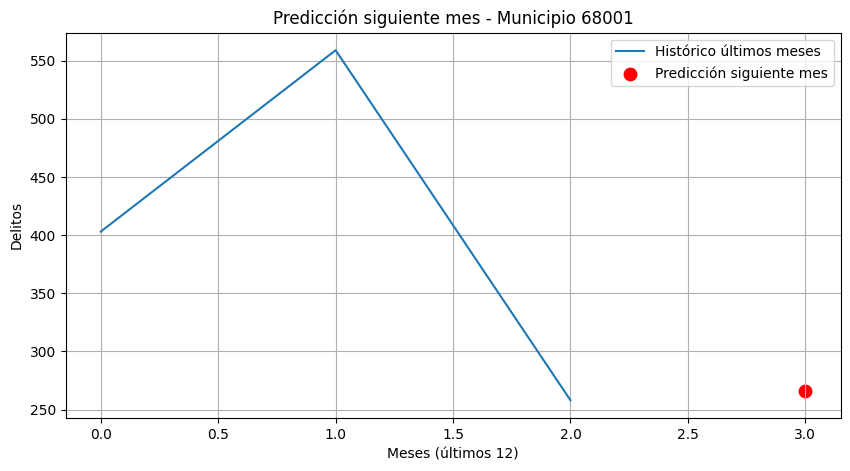

In [11]:
pred_df = predecir_siguiente_mes(df_prep, model, feature_cols)
pred_df.to_csv(os.path.join(output_dir, 'infernecia_total_delitos.csv'), index=False)
display(pred_df.head())
graficar_prediccion(df_prep, pred_df, codigo=68001)